In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [24]:
data = pd.read_csv("D:\\4TH YEAR\\FYP\\taasha\\real_BABY.csv")

In [25]:
input_features = ['Timestamp', 'volData', 'currentData']
output_features = ['batTempData', 'socData', 'sohData', 'motTempData', 'speedData']

In [26]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X = scaler_x.fit_transform(data[input_features])
y = scaler_y.fit_transform(data[output_features])


In [27]:
n = 1
X_downsampled = X[::n, :]
y_downsampled = y[::n, :]

In [34]:
def create_sequences(X, y, input_timesteps, output_timesteps):
    X_seq, y_seq = [], []
    for i in range(input_timesteps, len(X) - output_timesteps):
        X_seq.append(X[i - input_timesteps:i, :])
        y_seq.append(y[i + output_timesteps - 1, :])  # Predict only the last time step
    return np.array(X_seq), np.array(y_seq)
input_timesteps = 60
output_timesteps = 30
X_lstm, y_lstm = create_sequences(X_downsampled, y_downsampled, input_timesteps, output_timesteps)

In [35]:
train_size = int(len(X_lstm) * 0.8)
X_train, X_test = X_lstm[:train_size], X_lstm[train_size:]
y_train, y_test = y_lstm[:train_size], y_lstm[train_size:]

In [36]:
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(input_timesteps, X_lstm.shape[2]), kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    LSTM(32, kernel_regularizer=l2(1e-4)),
    Dense(128, activation='relu'),
    Dense(len(output_features))
])


In [37]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [38]:
checkpoint = ModelCheckpoint('LSTM_model_chkpt_bst.keras',monitor='val_loss',save_best_only=True)

In [39]:
history = model.fit(
    X_train, y_train,  # Train on full sequence output
    epochs=150, batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint]
)

Epoch 1/150


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - loss: 1.0657 - mae: 0.7468 - val_loss: 0.5601 - val_mae: 0.5470
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.8850 - mae: 0.6653 - val_loss: 0.6472 - val_mae: 0.6318
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.7063 - mae: 0.5665 - val_loss: 0.6593 - val_mae: 0.6444
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.8137 - mae: 0.5586 - val_loss: 0.6114 - val_mae: 0.5963
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.6542 - mae: 0.4928 - val_loss: 0.6368 - val_mae: 0.6252
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.7701 - mae: 0.4577 - val_loss: 0.6263 - val_mae: 0.6326
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.4568 - mae: 0.3963 - val_loss: 0.7530 - val_mae: 0.6880
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.4694 - mae: 0.4066 - val_loss: 0.6519 - val_mae: 0.6344
Epoch 9/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.5165 

In [52]:
model.save('LSTM_final_model.keras')

In [53]:
checkpoint_path = 'LSTM_final_model.keras'

In [54]:
y_pred = model.predict(X_test)
best_model = load_model(checkpoint_path)
y_pred = best_model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


In [55]:
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1]))

In [56]:
overall_mape = 100 - mean_absolute_percentage_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten()) * 100
overall_r2 = r2_score(y_test_rescaled.flatten(), y_pred_rescaled.flatten())

In [57]:
print(f"\nOverall Model Performance:")
print(f"Overall Accuracy: {overall_mape:.2f}%")
print(f"Overall R² Score: {overall_r2:.4f}")



Overall Model Performance:
Overall Accuracy: 95.10%
Overall R² Score: 0.9880


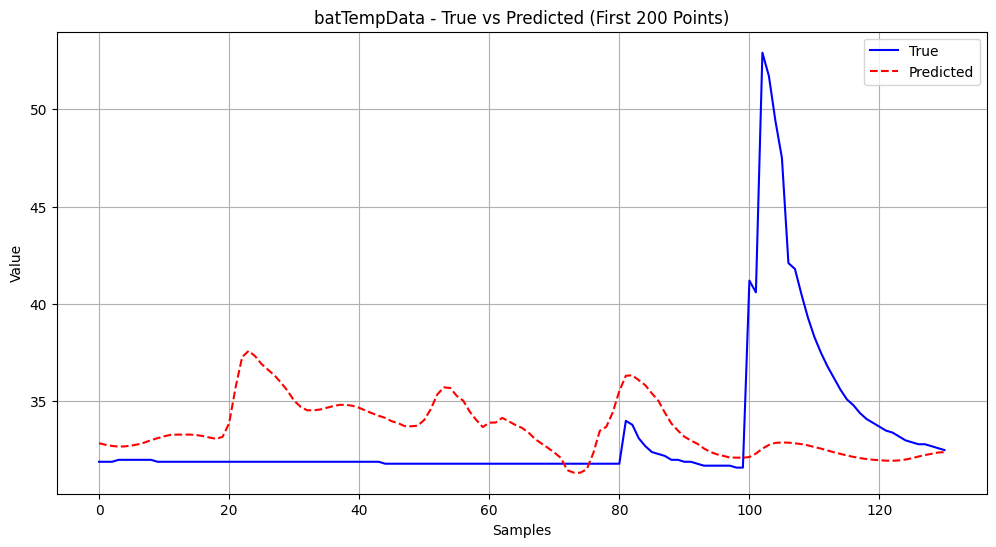

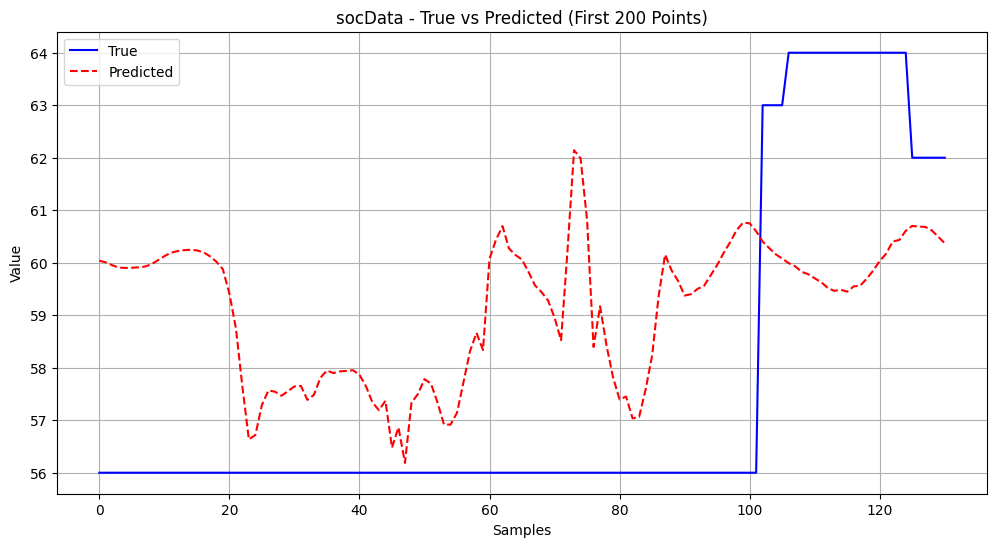

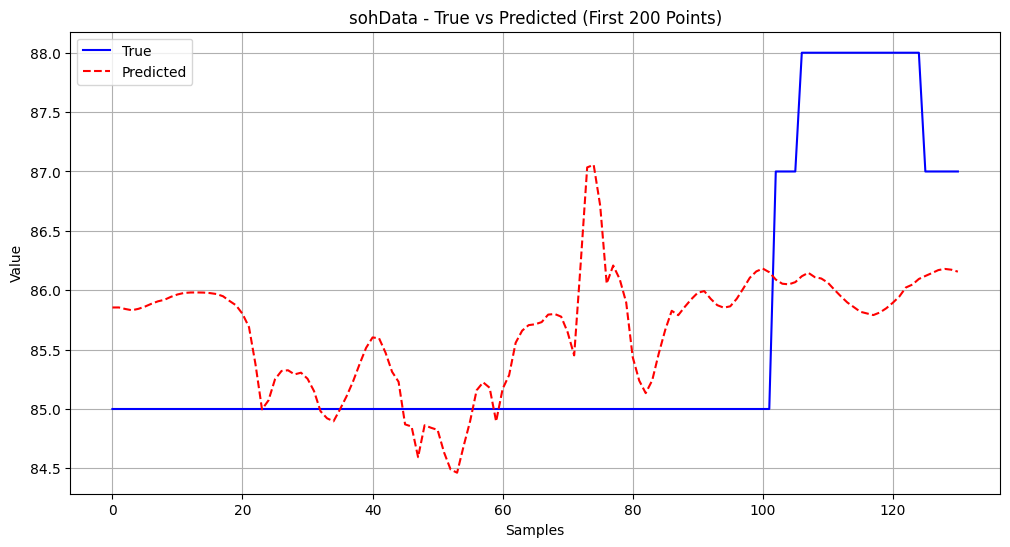

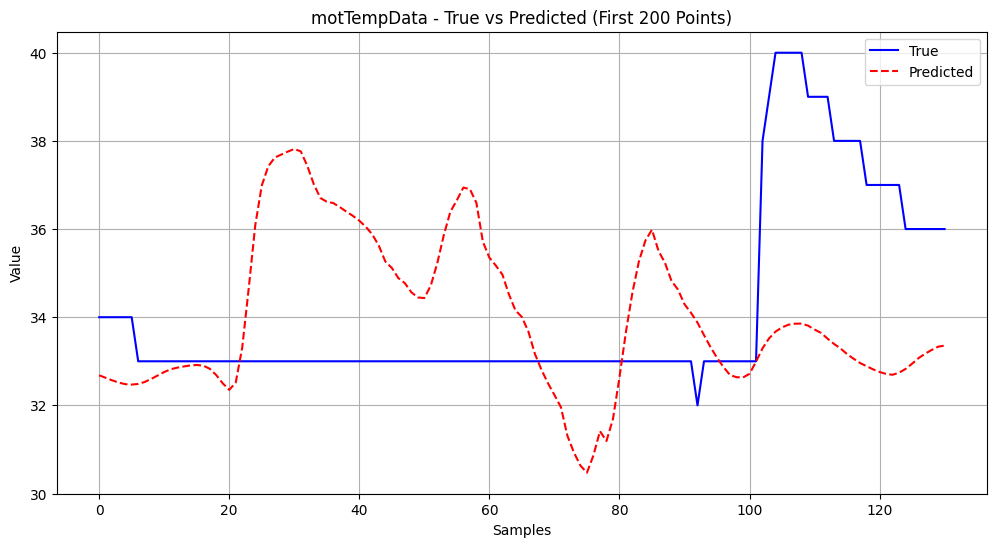

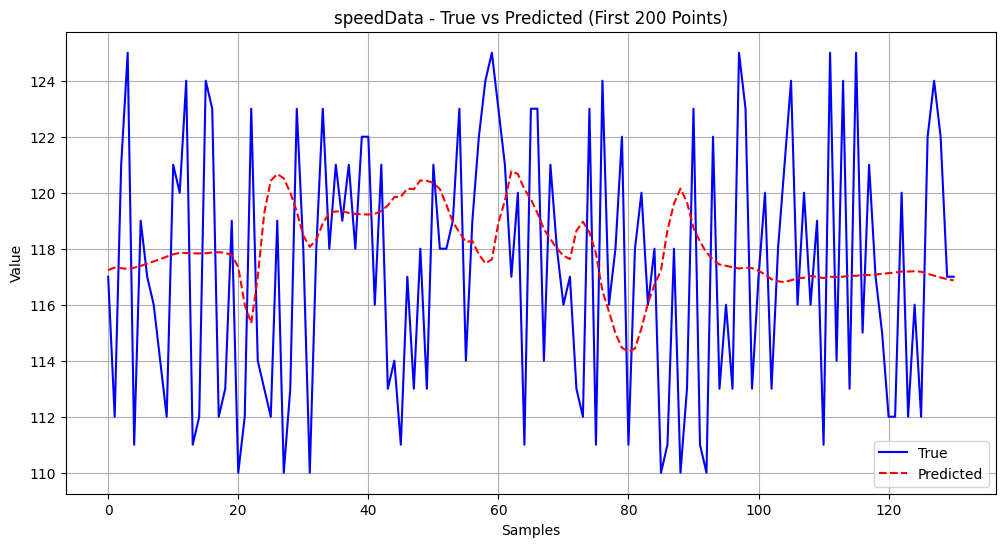

In [58]:
for i, feature in enumerate(output_features):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_rescaled[:200, i], 'b-', label='True')
    plt.plot(y_pred_rescaled[:200, i], 'r--', label='Predicted')
    plt.title(f'{feature} - True vs Predicted (First 200 Points)')
    plt.xlabel('Samples')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


In [60]:
def predict_custom_input(custom_input):
    if len(custom_input) != scaler_x.n_features_in_:
        raise ValueError(f"Expected {scaler_x.n_features_in_} features, but got {len(custom_input)}.")
    custom_input_scaled = scaler_x.transform(np.array(custom_input).reshape(1, -1))
    if input_timesteps > 1:
        custom_input_scaled = np.repeat(custom_input_scaled, input_timesteps, axis=0)
    custom_input_scaled = custom_input_scaled.reshape((1, input_timesteps, custom_input_scaled.shape[1]))
    custom_pred_scaled = best_model.predict(custom_input_scaled)
    custom_pred = scaler_y.inverse_transform(custom_pred_scaled)
    return custom_pred

# Sample Custom Input Prediction
sample_input = [0, 3.77832, 0.287739]
predicted_output = predict_custom_input(sample_input)
print("\nCustom Input Prediction:")
for i, feature in enumerate(output_features):
    print(f"{feature}: {predicted_output[0][i]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Custom Input Prediction:
batTempData: 32.7133
socData: 68.7992
sohData: 89.0612
motTempData: 34.0857
speedData: 117.9664


c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
